In [18]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [19]:
from pathlib import Path
import torchaudio
import fairseq
import torch
device = torch.device('cuda')
device

device(type='cuda')

In [20]:
def get_mos_data(split):
    mos_list_file = f'../data/phase1-main/DATA/sets/{split}_mos_list.txt'
    mos_data = {}
    for line in open(mos_list_file):
        file_id, mos = line.rstrip().split(',')
        mos = float(mos)
        mos_data[file_id] = mos
    return mos_data

In [21]:
train_mos_data = get_mos_data('train')
len(train_mos_data)

4974

In [22]:
val_mos_data = get_mos_data('val')
len(val_mos_data)

1066

In [23]:
wav_dir = Path('../data/phase1-main/DATA/wav/')

wavpath = wav_dir / 'sys64e2f-utt9c183cd.wav'
wav = torchaudio.load(wavpath)[0]
wav.size()

torch.Size([1, 42944])

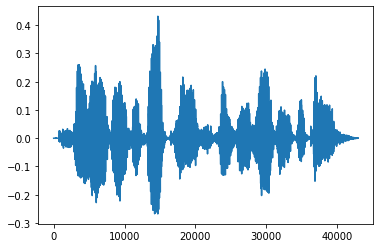

In [24]:
plt.plot(wav.numpy().ravel())

In [25]:
fairseq_base_model = '../fairseq/wav2vec_vox_new.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([fairseq_base_model])
# model

In [26]:
ssl_model = model[0]

In [27]:
ssl_model.remove_pretraining_modules()
ssl_model.to(device)
ssl_model.eval();

In [28]:
output_wavs = torch.stack([wav], dim=0)
output_wavs.size()

torch.Size([1, 1, 42944])

In [29]:
res = ssl_model(wav.to(device), mask=False, features_only=True)
res

{'x': tensor([[[-3.4026e-06, -1.0513e-05,  1.1770e-02,  ..., -2.2333e-05,
           -7.0605e-06, -4.6998e-06],
          [-3.5713e-06, -1.0697e-05,  2.5893e-02,  ..., -2.1212e-05,
           -7.1905e-06, -5.6001e-06],
          [-4.1687e-06, -1.1108e-05,  5.8704e-02,  ..., -1.9214e-05,
           -7.4507e-06, -7.6142e-06],
          ...,
          [-4.0837e-06, -1.1021e-05,  5.5975e-02,  ..., -1.9256e-05,
           -7.5210e-06, -7.2366e-06],
          [-4.1706e-06, -1.0984e-05,  6.0588e-02,  ..., -1.8904e-05,
           -7.4214e-06, -7.4529e-06],
          [-4.2616e-06, -1.1095e-05,  6.4690e-02,  ..., -1.8458e-05,
           -7.4688e-06, -7.6801e-06]]], device='cuda:0',
        grad_fn=<NativeLayerNormBackward0>),
 'padding_mask': None,
 'features': tensor([[[ 0.6163, -1.0448, -0.6485,  ..., -1.1529,  0.0493, -0.4122],
          [ 0.6190, -1.0467, -0.6853,  ..., -1.1549,  0.1776, -0.5205],
          [ 0.8388, -0.7912, -0.7703,  ..., -0.6035, -0.8502, -0.2669],
          ...,
        

In [30]:
res['x'].size()

torch.Size([1, 133, 1024])

In [31]:
res['features'].size()

torch.Size([1, 133, 512])

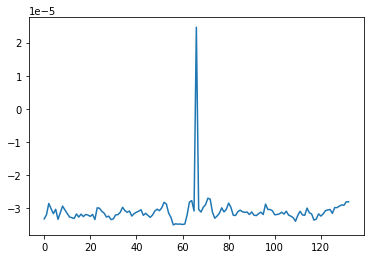

In [32]:
plt.plot(res['x'].squeeze(0)[:, 350].detach().cpu().numpy())

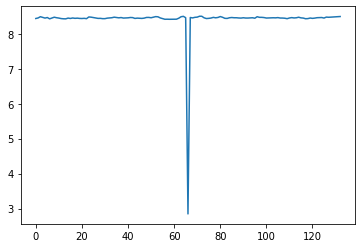

In [33]:
plt.plot(torch.linalg.vector_norm(res['x'].squeeze(0), dim=1).detach().cpu().numpy())

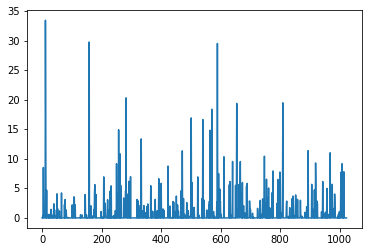

In [34]:
plt.plot(torch.linalg.vector_norm(res['x'].squeeze(0), dim=0).detach().cpu().numpy())

In [35]:
def extract_mean(wavpath):
    with torch.no_grad():
        wav = torchaudio.load(wavpath)[0]
        res = ssl_model(wav.to(device), mask=False, features_only=True)
        return res['x'].squeeze(0).mean(dim=0)


In [36]:
extract_mean(wavpath).size()

torch.Size([1024])

In [37]:
out_dir = Path('../out/utt_data/w2v_large')
import os
os.makedirs(out_dir, exist_ok=True)


In [38]:
val_vecs = []
val_moss = []

for key, mos in tqdm(sorted(val_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    val_vecs.append(vec)
    val_moss.append(mos)

  0%|          | 0/1066 [00:00<?, ?it/s]

In [39]:
train_vecs = []
train_moss = []

for key, mos in tqdm(sorted(train_mos_data.items())):
    wavpath = wav_dir / key
    vec = extract_mean(wavpath)
    outpath = out_dir / (wavpath.stem + '.npy')
    
    vec = vec.detach().cpu().numpy()
    np.save(outpath, vec)
    
    train_vecs.append(vec)
    train_moss.append(mos)

  0%|          | 0/4974 [00:00<?, ?it/s]

In [40]:
train_X = np.array(train_vecs)
train_y = np.array(train_moss)
val_X = np.array(val_vecs)
val_y = np.array(val_moss)
train_X.shape

(4974, 1024)

In [41]:
uttemb_dir = Path('../out/utt_emb/w2v_large')
os.makedirs(uttemb_dir)
np.save(uttemb_dir / 'train_X.npy', train_X)
np.save(uttemb_dir / 'train_y.npy', train_y)
np.save(uttemb_dir / 'val_X.npy', val_X)
np.save(uttemb_dir / 'val_y.npy', val_y)

FileExistsError: [Errno 17] File exists: '../out/utt_emb/w2v_large'